### Autoencoder + clustering method
This MSE/SSE classification method consists of using an autoencoder to extract predictors and group data into cluster.

In [1]:
from begepro.rw import CAENhandler
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from begepro.dspro import filters as flt
import autoencoder.dataloading as dl
import autoencoder.autoencoder as aut
import tensorflow as tf
import pickle
from tensorflow import keras
from sklearn.cluster import DBSCAN

# %matplotlib widget

from numpy.random import seed
from numpy.random import rand
seed(7)
tf.random.set_seed(
    42
)

2023-01-24 17:22:35.530540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 17:22:35.641670: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 17:22:35.641689: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 17:22:36.190338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Loading preprocessed data and splitting into train and validation
data_path = "../../dataset/Th232"
waveforms, currents, energies, amplitudes, pulse_height = dl.load(data_path)

data_train, data_val, data_test = dl.train_val_test_split(waveforms, energies, amplitudes, pulse_height)
wf_train = data_train[0]

# Loading the pre-trained encoder and encoding waveforms into a small number of highly representative features
encoder = keras.models.load_model("../../models/encoder", compile=False)
encoded_data = encoder.predict(wf_train[:50000]) # selecting only 5e4 events for clustering efficiency
encoded_data, _, _ = dl.standardize_data(encoded_data) # Centering data to zero mean and unitary standard deviation

# Computing the A/E ratio for benchmark
avse = data_train[-2][:50000] / data_train[-1][:50000]

2023-01-24 17:22:43.000205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-24 17:22:43.002486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DARTWARS0): /proc/driver/nvidia/version does not exist
2023-01-24 17:22:43.004743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1563/1563 [==============================] - 1s 814us/step


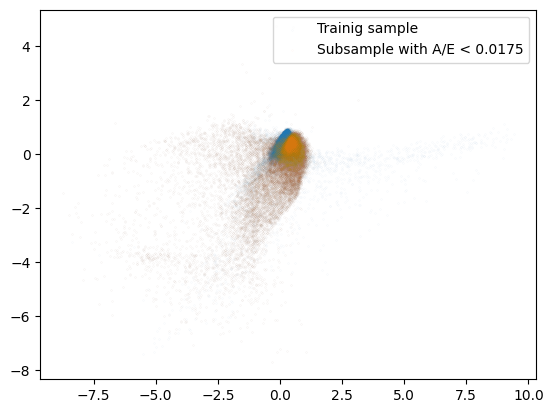

In [3]:
# Plotting two out of the 5 encoder variables
arbitrary_avse_threshold = 0.0175
plt.scatter(encoded_data[:,0], encoded_data[:,1], s = 0.001, alpha = 0.5)
plt.scatter(encoded_data[avse < arbitrary_avse_threshold,0], encoded_data[avse < arbitrary_avse_threshold,1], s = 0.001, alpha = 0.5)
plt.legend(["Trainig sample", "Subsample with A/E < "+str(arbitrary_avse_threshold)])

In [4]:
# Executing the clustering algorithm and extracting the predictions
DBSCAN_cluster = DBSCAN(eps=0.1, min_samples=50).fit(encoded_data) 
predictions = -1 * DBSCAN_cluster.labels_

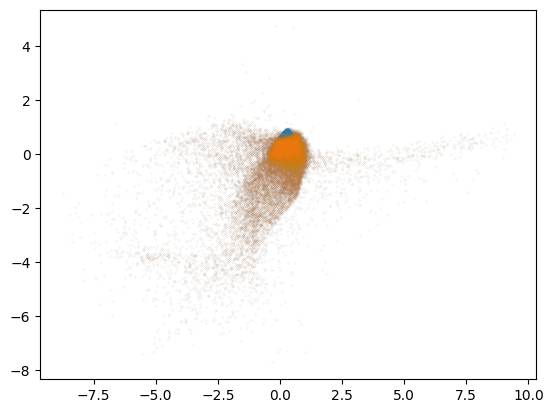

In [5]:
plt.scatter(encoded_data[:,0], encoded_data[:,1], s = 0.001)
plt.scatter(encoded_data[predictions == 1,0], encoded_data[predictions == 1,1], s = 0.001)

In [6]:
# Preparing a subsample selected with the A/E method
clustering_selection =  data_train[1][:50000][predictions == 1]
threshold = dl.compute_avse_threshold(avse, clustering_selection.shape[0])
avse_selection =  data_train[1][:50000][avse < threshold]

print(clustering_selection.shape)
print(avse_selection.shape)

(26259,)
(26259,)


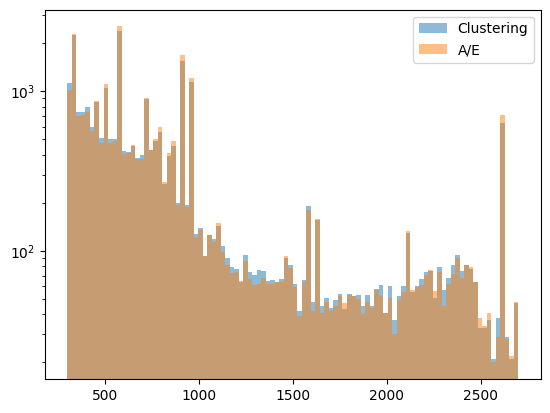

In [7]:
# Plotting the selected spectrum for a preliminary comparison
plt.hist(clustering_selection, range = [300, 2700], bins = 100, alpha = 0.5)[-1]
plt.hist(avse_selection, range = [300, 2700], bins = 100, alpha = 0.5)[-1]

plt.yscale("log")
plt.legend(["Clustering", "A/E"])